In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set()

import os

In [3]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import leastsq
import math

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn import model_selection
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
import scipy.signal as sg
warnings.filterwarnings("ignore")

from scipy import stats

In [5]:
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.python.keras.layers import Dropout, Lambda
from tensorflow.python.keras.layers import ReLU, LeakyReLU, BatchNormalization, Conv1D, Flatten
from tensorflow.python.keras.layers import Add, Bidirectional, LSTM, AveragePooling2D, MaxPooling2D, MaxPooling1D
from tensorflow.python.keras.layers import Embedding, concatenate, Reshape
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow.python.keras

In [6]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow_hub as hub

In [7]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: #and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: #and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
def reduce_mem_usage_col(df, col, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    #for col in df.columns:
    col_type = df[col].dtypes

    if col_type in numerics:
        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        else:
            c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: #and c_prec == np.finfo(np.float16).precision:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: #and c_prec == np.finfo(np.float32).precision:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
from math import sqrt
def root_mean_squared_error(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [10]:
def train_model_regression_Zillow(X, y, params, groups, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame
    :params: X_test - test data, can be pd.DataFrame
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    #X_test = X_test[columns]
    models = []
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    #'group_mae': {'lgb_metric_name': 'mae',
                    #    'catboost_metric_name': 'MAE',
                    #    'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error},
                    'rmse': {'lgb_metric_name': 'rmse',
                        'catboost_metric_name': 'RMSE',
                        'sklearn_scoring_function': root_mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    # prediction = np.zeros((6,len(X_test)))
    
    # list of scores on folds
    scores = []
    train_loss = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    if groups is None:
        splits = folds.split(X)
        print('yes')
    else:
        splits = folds.split(X, groups = groups)
        print('no')
        
    for fold_n, (train_index, valid_index) in enumerate(splits):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred_train = model.predict(X_train)
            models.append(model)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred_train = model.predict(xgb.DMatrix(X_train, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            #y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            models.append(model)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            #y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred_train = model.predict(X_train)
            #y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            train_loss.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_train, y_pred_train))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        #prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    #prediction /= folds.n_splits
    
    print('Train loss mean: {0:.6f}, std: {1:.6f}.'.format(np.mean(train_loss), np.std(train_loss)))
    print('CV mean score: {0:.6f}, std: {1:.6f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    #result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['models'] = models
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [11]:
def train_model_classification_Zillow(X, y, params, groups, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame
    :params: X_test - test data, can be pd.DataFrame
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    #X_test = X_test[columns]
    models = []
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': 'auc',
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    # prediction = np.zeros((6,len(X_test)))
    
    # list of scores on folds
    scores = []
    train_loss = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    if groups is None:
        splits = folds.split(X)
        print('yes')
    else:
        splits = folds.split(X, groups = groups)
        print('no')
        
    for fold_n, (train_index, valid_index) in enumerate(splits):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred_train = model.predict_proba(X_train)[:, 1]
            models.append(model)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred_train = model.predict(xgb.DMatrix(X_train, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            #y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            models.append(model)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            #y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred_train = model.predict(X_train)
            #y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            train_loss.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_train, y_pred_train))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        #prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    #prediction /= folds.n_splits
    
    print('Train loss mean: {0:.6f}, std: {1:.6f}.'.format(np.mean(train_loss), np.std(train_loss)))
    print('CV mean score: {0:.6f}, std: {1:.6f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    #result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['models'] = models
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [12]:
def test_predict(df, models, features, year):
    # features: end with year, month, month_block
    months = [10, 11, 12]
    for month in months:
        df['year'] = year
        df['year'] = df['year'].astype('int16')
        df['month'] = month
        df['month'] = df['month'].astype('int8')
        df['month_block'] = month + (year-2016)*12
        df['month_block'] = df['month_block'].astype('int8')
        
        n_models = len(models)
        y_pred =  np.zeros(len(df))
        
        features_old = {feature.replace(f'_{month}',''):feature for feature in df.columns if (f'_{month}' in feature) }
        features_new = {value:key for key, value in features_old.items()}
        df.rename(columns=features_new, inplace = True)
    
        for model in models:
            y_pred += model.predict(df[features])
            gc.collect()
            
        y_pred /= n_models
        df.rename(columns=features_old, inplace = True)

        test_2017[str(year) + str(month)] = y_pred

In [13]:
def test_prob_predict(df, models, features, year):
    # features: end with year, month, month_block
    months = [10, 11, 12]
    for month in months:
        df['year'] = year
        df['year'] = df['year'].astype('int16')
        df['month'] = month
        df['month'] = df['month'].astype('int8')
        df['month_block'] = month + (year-2016)*12
        df['month_block'] = df['month_block'].astype('int8')
        gc.collect()
        n_models = len(models)
        y_pred =  np.zeros(len(df))
        features_use = [feature if '_lag_' not in feature else f'{feature}_{month}' for feature in features]
        for model in models:
            y_pred += model.predict_proba(df[features_use])[:, 1]
        y_pred /= n_models

        test_2017[str(year) + str(month)+'_prob'] = y_pred

# Data Preparation

In [32]:
properties_2016 = pd.read_csv('./input/properties_2016.csv')
properties_2017 = pd.read_csv('./input/properties_2017.csv')
train_2016 = pd.read_csv('./input/train_2016_v2.csv')
train_2017 = pd.read_csv('./input/train_2017.csv')
test_2016 = pd.read_csv('./input/sample_submission.csv')
test_2017 = test_2016.copy()

Create a uniform properties dataframe

In [15]:
properties_2016 = properties_2016.sort_values(by=['parcelid'])
properties_2017 = properties_2017.sort_values(by=['parcelid'])

In [16]:
all_features = properties_2016.columns.values
properties_2017.columns = [str(feature)+'_2017' for feature in properties_2016.columns]
properties_2017.rename({'parcelid_2017':'parcelid'},axis = 1,inplace=True)
properties_2016 = pd.merge(properties_2016, properties_2017, how='left', on='parcelid')

In [17]:
features_exclude = ['parcelid','unitcnt_2017','structuretaxvaluedollarcnt_2017','taxvaluedollarcnt_2017','landtaxvaluedollarcnt_2017']
cat_features = [feature for feature in properties_2017.columns if ('id' in feature)|('cnt' in feature)|('nbr' in feature)]
cat_features = [feature.replace('_2017','') for feature in cat_features if feature not in features_exclude]

In [18]:
for feature in cat_features:
    if feature == 'parcelid':
        continue
    properties_2016.loc[(properties_2016[feature].isnull())&(properties_2016[f'{feature}_2017'].notnull()),feature]=\
    properties_2016.loc[(properties_2016[feature].isnull())&(properties_2016[f'{feature}_2017'].notnull()),f'{feature}_2017']
    
    properties_2016.loc[(properties_2016[feature].notnull())&(properties_2016[f'{feature}_2017'].isnull()),f'{feature}_2017']=\
    properties_2016.loc[(properties_2016[feature].notnull())&(properties_2016[f'{feature}_2017'].isnull()),feature]
    
    na_value = min(properties_2016[feature].min(),properties_2016[f'{feature}_2017'].min()) - 1
    properties_2016.fillna({feature: na_value,
                  f'{feature}_2017': na_value},
                          inplace = True)

Merge low cardinality data

In [19]:
features = ['regionidcity','regionidzip','regionidneighborhood','propertycountylandusecode']
for feature in features:
    print(feature)
    
    group = properties_2016.groupby(feature).agg({feature:'count'})
    group.columns = ['count']
    group.reset_index(inplace=True)

    threshould = 100
    lst = group.loc[group['count']<threshould,feature].unique()
    if len(lst) == 0:
        continue
    value_replace = lst.min()
    properties_2016.loc[properties_2016[feature].isin(lst),feature] = value_replace
    properties_2016.loc[properties_2016[f'{feature}_2017'].isin(lst),f'{feature}_2017'] = value_replace
    #train_2016.loc[train_2016[feature].isin(lst),feature] = value_replace
    #train_2017.loc[train_2017[feature].isin(lst),feature] = value_replace

regionidcity
regionidzip
regionidneighborhood
propertycountylandusecode


Merge properties dataset with corresponding train dataset

In [20]:
train_2016.rename(columns={'parcelid': 'ParcelId'}, inplace=True)
train_2017.rename(columns={'parcelid': 'ParcelId'}, inplace=True)
properties_2016.rename(columns={'parcelid': 'ParcelId'}, inplace=True)
properties_2017.rename(columns={'parcelid': 'ParcelId'}, inplace=True)

In [21]:
features_2016 = properties_2016.columns.values[:58]
features_2017 = np.append(properties_2016.columns.values[58:],['ParcelId'])

In [22]:
train_2016 = pd.merge(train_2016, properties_2016[features_2016], how = 'left', on=['ParcelId'])
train_2017 = pd.merge(train_2017, properties_2016[features_2017], how = 'left', on=['ParcelId'])

In [23]:
test_2016 = pd.merge(test_2016, properties_2016[features_2016], how='left', on=['ParcelId'])
test_2017 = pd.merge(test_2017, properties_2016[features_2017], how='left', on=['ParcelId'])

In [24]:
train_2016['date'] = pd.to_datetime(train_2016['transactiondate'])
train_2016['year'] = train_2016['date'].apply(lambda x: x.year)
train_2016['month'] = train_2016['date'].apply(lambda x: x.month)
train_2016['day'] = train_2016['date'].apply(lambda x: x.day)
train_2016['month_block'] = (train_2016['year'] - 2016)*12 + train_2016['month']

train_2016.drop(['transactiondate', 'date', 
                 'day'],axis=1, inplace = True)

In [25]:
train_2017['date'] = pd.to_datetime(train_2017['transactiondate'])
train_2017['year'] = train_2017['date'].apply(lambda x: x.year)
train_2017['month'] = train_2017['date'].apply(lambda x: x.month)
train_2017['day'] = train_2017['date'].apply(lambda x: x.day)
train_2017['month_block'] = (train_2017['year'] - 2016)*12 + train_2017['month']

train_2017.drop(['transactiondate', 'date', 
                 'day'],axis=1, inplace = True)

In [26]:
train_2017.columns = [feature.replace('_2017','') if '_2017' in feature else feature for feature in train_2017.columns]
test_2017.columns = [feature.replace('_2017','') if '_2017' in feature else feature for feature in test_2017.columns]

In [27]:
columns = ['regionidcounty','regionidcity','regionidneighborhood','regionidzip']
for column in columns:
    
    train_2016[column] = train_2016[column].astype('int32')
    train_2017[column] = train_2017[column].astype('int32')
    test_2016[column] = test_2016[column].astype('int32')
    test_2017[column] = test_2017[column].astype('int32')

In [28]:
features = ['bathroomcnt','calculatedbathnbr']

for feature in features:
    train_2016[feature] = train_2016[feature]*10
    train_2017[feature] = train_2017[feature]*10
    test_2016[feature] = test_2016[feature]*10
    test_2017[feature] = test_2017[feature]*10

In [29]:
for column in test_2016.columns:
    if test_2016[column].dtypes == 'object':
        print(column)
        test_2016[column] = test_2016[column].astype(str)
        test_2017[column] = test_2017[column].astype(str)
        train_2016[column] = train_2016[column].astype(str)
        train_2017[column] = train_2017[column].astype(str)
        
        lb = LabelEncoder()
        
        lb = lb.fit(list(set(test_2017[column].unique()).union(set(test_2016[column]))))
        test_2017[column] = lb.transform(test_2017[column])
        test_2016[column] = lb.transform(test_2016[column])
        train_2016[column] = lb.transform(train_2016[column])
        train_2017[column] = lb.transform(train_2017[column])

hashottuborspa
propertycountylandusecode
propertyzoningdesc
fireplaceflag
taxdelinquencyflag


In [30]:
# Take log of some highly skewed features. This can also possibly helps save space

columns = ['calculatedfinishedsquarefeet', 'finishedsquarefeet50', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
          'taxamount', 'landtaxvaluedollarcnt', 'lotsizesquarefeet', 'finishedsquarefeet6', 'garagetotalsqft',
          'finishedsquarefeet12', 'unitcnt', 'finishedsquarefeet15', 'finishedfloor1squarefeet', 'longitude']
for column in columns:
    if column not in train_2016.columns:
        continue
    # +0.1 to avoid log0
    train_2016[f'{column}_log'] = np.log(train_2016[column]+0.1)
    train_2017[f'{column}_log'] = np.log(train_2017[column]+0.1)
    test_2016[f'{column}_log'] = np.log(test_2016[column]+0.1)
    test_2017[f'{column}_log'] = np.log(test_2017[column]+0.1)
    
train_2016.drop(columns, axis=1, inplace = True)
train_2017.drop(columns, axis=1, inplace = True)
test_2016.drop(columns, axis=1, inplace = True)
test_2017.drop(columns, axis=1, inplace = True)

In [31]:
del properties_2016
del properties_2017
gc.collect()

371

In [32]:
ts = time.time()

train_2016 = reduce_mem_usage(train_2016)
train_2017 = reduce_mem_usage(train_2017)
test_2016 = reduce_mem_usage(test_2016)
test_2017 = reduce_mem_usage(test_2017)

gc.collect()

time.time() - ts

Mem. usage decreased to 12.57 Mb (70.1% reduction)
Mem. usage decreased to 10.81 Mb (70.1% reduction)
Mem. usage decreased to 415.65 Mb (71.0% reduction)
Mem. usage decreased to 415.65 Mb (71.0% reduction)


638.8886218070984

# Feature Engineering

In [33]:
# Example of how aggregated features are going to be created
def aggregated_feature(df_tr_2016, df_tr_2017, df_test_2016, df_test_2017, gpfeat, tgfeat):
    
    if type(gpfeat) is list:
        gpfeat_name = '_'.join(gpfeat)
    else:
        gpfeat_name = gpfeat
        
    # Add a step to convert datatype of tgfeat to avoid trouble during the aggregation
    
    df_test_2016_group = df_test_2016.groupby(gpfeat).agg({tgfeat:[#'sum',
                                                                   'mean',
                                                                    #'std'
    ]})
    df_test_2016_group.columns = [f'{gpfeat_name}_{tgfeat}_mean',
                                 # f'{gpfeat_name}_{tgfeat}_std'
                                 ]
    df_test_2016_group.reset_index(inplace = True)

    df_tr_2016 = pd.merge(df_tr_2016, df_test_2016_group, how = 'left', on=[gpfeat])
    df_test_2016 = pd.merge(df_test_2016, df_test_2016_group, how = 'left', on=[gpfeat])
    
    df_tr_2016[f'{gpfeat_name}_{tgfeat}_dif'] = df_tr_2016[f'{gpfeat_name}_{tgfeat}_mean'] - df_tr_2016[tgfeat]
    df_test_2016[f'{gpfeat_name}_{tgfeat}_dif'] = df_test_2016[f'{gpfeat_name}_{tgfeat}_mean'] - df_test_2016[tgfeat]

    df_tr_2016[f'{gpfeat_name}_{tgfeat}_ratio'] = df_tr_2016[f'{gpfeat_name}_{tgfeat}_dif']/df_tr_2016[f'{gpfeat_name}_{tgfeat}_mean']
    df_test_2016[f'{gpfeat_name}_{tgfeat}_ratio'] = df_test_2016[f'{gpfeat_name}_{tgfeat}_dif']/df_test_2016[f'{gpfeat_name}_{tgfeat}_mean']

    df_test_2017_group = df_test_2017.groupby([gpfeat]).agg({tgfeat:[#'sum',
                                                                     'mean',
                                                                    #'std'
    ]})
    df_test_2017_group.columns = [f'{gpfeat_name}_{tgfeat}_mean',
                                 # f'{gpfeat_name}_{tgfeat}_std'
                                 ]
    df_test_2017_group.reset_index(inplace = True)

    df_tr_2017 = pd.merge(df_tr_2017, df_test_2017_group, how = 'left', on=[gpfeat])
    df_test_2017 = pd.merge(df_test_2017, df_test_2017_group, how = 'left', on=[gpfeat])
    
    df_tr_2017[f'{gpfeat_name}_{tgfeat}_dif'] = df_tr_2017[f'{gpfeat_name}_{tgfeat}_mean'] - df_tr_2017[tgfeat]
    df_test_2017[f'{gpfeat_name}_{tgfeat}_dif'] = df_test_2017[f'{gpfeat_name}_{tgfeat}_mean'] - df_test_2017[tgfeat]

    df_tr_2017[f'{gpfeat_name}_{tgfeat}_ratio'] = df_tr_2017[f'{gpfeat_name}_{tgfeat}_dif']/df_tr_2017[f'{gpfeat_name}_{tgfeat}_mean']
    df_test_2017[f'{gpfeat_name}_{tgfeat}_ratio'] = df_test_2017[f'{gpfeat_name}_{tgfeat}_dif']/df_test_2017[f'{gpfeat_name}_{tgfeat}_mean']
    
    return df_tr_2016, df_tr_2017, df_test_2016, df_test_2017

In [34]:
ts = time.time()

train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcounty','taxvaluedollarcnt_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcity','taxvaluedollarcnt_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidneighborhood','taxvaluedollarcnt_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidzip','taxvaluedollarcnt_log')

gc.collect()
time.time() - ts

64.2725477218628

In [35]:
ts = time.time()

train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcounty','lotsizesquarefeet_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcity','lotsizesquarefeet_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidneighborhood','lotsizesquarefeet_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidzip','lotsizesquarefeet_log')

gc.collect()
time.time() - ts

80.43468737602234

In [36]:
ts = time.time()

train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcounty','finishedsquarefeet12_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcity','finishedsquarefeet12_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidneighborhood','finishedsquarefeet12_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidzip','finishedsquarefeet12_log')

gc.collect()
time.time() - ts

93.0888249874115

In [37]:
ts = time.time()

train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcounty','landtaxvaluedollarcnt_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcity','landtaxvaluedollarcnt_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidneighborhood','landtaxvaluedollarcnt_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidzip','landtaxvaluedollarcnt_log')

gc.collect()
time.time() - ts

108.06228709220886

In [38]:
ts = time.time()

train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcounty','yearbuilt')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcity','yearbuilt')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidneighborhood','yearbuilt')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidzip','yearbuilt')

gc.collect()
time.time() - ts

122.69045376777649

In [39]:
ts = time.time()

train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcounty','taxamount_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcity','taxamount_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidneighborhood','taxamount_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidzip','taxamount_log')

gc.collect()
time.time() - ts

136.63302087783813

In [40]:
ts = time.time()

train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcounty','structuretaxvaluedollarcnt_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcity','structuretaxvaluedollarcnt_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidneighborhood','structuretaxvaluedollarcnt_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidzip','structuretaxvaluedollarcnt_log')

gc.collect()
time.time() - ts

150.57966876029968

In [41]:
ts = time.time()

train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcounty','calculatedfinishedsquarefeet_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidcity','calculatedfinishedsquarefeet_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidneighborhood','calculatedfinishedsquarefeet_log')
train_2016, train_2017, test_2016, test_2017 = \
        aggregated_feature(train_2016, train_2017, test_2016, test_2017, 'regionidzip','calculatedfinishedsquarefeet_log')

gc.collect()
time.time() - ts

163.3737895488739

In [42]:
train_2016['num_of_nan'] = train_2016.isnull().sum(axis=1)
train_2017['num_of_nan'] = train_2017.isnull().sum(axis=1)

test_2016['num_of_nan'] = test_2016.isnull().sum(axis=1)
test_2017['num_of_nan'] = test_2017.isnull().sum(axis=1)

In [46]:
train_2016 = train.loc[train['year']==2016]
train_2017 = train.loc[train['year']==2017]

In [47]:
with open('train_2016.pickle', 'wb') as handle:
    pickle.dump(train_2016, handle, protocol = pickle.HIGHEST_PROTOCOL)

with open('test_2016.pickle', 'wb') as handle:
    pickle.dump(test_2016, handle, protocol = pickle.HIGHEST_PROTOCOL)

with open('train_2017.pickle', 'wb') as handle:
    pickle.dump(train_2017, handle, protocol = pickle.HIGHEST_PROTOCOL)
    
with open('test_2017.pickle', 'wb') as handle:
    pickle.dump(test_2017, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [14]:
with open('train_2016.pickle', 'rb') as handle:
    train_2016 = pickle.load(handle)
    
with open('train_2017.pickle', 'rb') as handle:
    train_2017 = pickle.load(handle)

with open('test_2016.pickle', 'rb') as handle:
    test_2016 = pickle.load(handle)
    
with open('test_2017.pickle', 'rb') as handle:
    test_2017 = pickle.load(handle)

In [15]:
train = train_2016.append(train_2017, ignore_index=True)
del train_2016, train_2017
gc.collect()

0

In [22]:
train['target'] = train['logerror'].clip(-0.2,0.2)

Target encoding

In [34]:
n_splits = 5
folds = KFold(n_splits)

In [35]:
def K_Fold_target_encoding(df_train, df_test_1, df_test_2, GCol, target, folds):
    
    if type(GCol) is list:
        GCol_use = '_'.join(GCol)
        GCol_use = '_'.join(GCol)
        df_train[GCol_use] = ''
        df_test_1[GCol_use] = ''
        df_test_2[GCol_use] = ''
        for col in GCol:
            df_train[GCol_use] = df_train[GCol_use] + df_train[col].astype(str) + '_'
            df_test_1[GCol_use] = df_test_1[GCol_use] + df_test_1[col].astype(str) + '_'
            df_test_2[GCol_use] = df_test_2[GCol_use] + df_test_2[col].astype(str) + '_'
        df_train[GCol_use]=df_train[GCol_use].str.strip('_')
        df_test_1[GCol_use]=df_test_1[GCol_use].str.strip('_')
        df_test_2[GCol_use]=df_test_2[GCol_use].str.strip('_')
        
    else:
        GCol_use = GCol
        
    colName = f'{GCol_use}_{target}_enc'
    mean_of_target = df_train[target].mean()
    
    df_train[colName] = np.nan
    
    for tr_ind, val_ind in folds.split(df_train):
        X_tr, X_val = df_train.iloc[tr_ind], df_train.iloc[val_ind]
        df_train.loc[df_train.index[val_ind], colName] = X_val[GCol_use].map(X_tr.groupby(GCol_use)[target].mean())
    
    group_mean = df_train.groupby(GCol_use).agg({target: ['mean']})
    group_mean.columns = [colName]
    group_mean.reset_index(inplace=True)
    
    df_test_1 = pd.merge(df_test_1, group_mean, how = 'left', on = GCol_use)
    df_test_2 = pd.merge(df_test_2, group_mean, how = 'left', on = GCol_use)
    
    del group_mean
    gc.collect()
    
    df_test_1[colName].fillna(mean_of_target, inplace = True)
    df_test_2[colName].fillna(mean_of_target, inplace = True)
    
    if type(GCol) is list:
        df_train.drop(GCol_use, axis=1, inplace=True)
        df_test_1.drop(GCol_use, axis=1, inplace=True)
        df_test_2.drop(GCol_use, axis=1, inplace=True)
    return df_train, df_test_1, df_test_2

In [20]:
ts = time.time()

train, test_2016, test_2017 = K_Fold_target_encoding(train, test_2016, test_2017, ['regionidcity','propertycountylandusecode'], 'target', folds)
train, test_2016, test_2017 = K_Fold_target_encoding(train, test_2016, test_2017, ['regionidzip','propertycountylandusecode'], 'target', folds)
train, test_2016, test_2017 = K_Fold_target_encoding(train, test_2016, test_2017, ['regionidneighborhood','propertycountylandusecode'], 'target', folds)

time.time() - ts

138.251935005188

In [36]:
ts = time.time()

train, test_2016, test_2017 = K_Fold_target_encoding(train, test_2016, test_2017, ['regionidcity','propertyzoningdesc'], 'target', folds)
train, test_2016, test_2017 = K_Fold_target_encoding(train, test_2016, test_2017, ['regionidzip','propertyzoningdesc'], 'target', folds)
train, test_2016, test_2017 = K_Fold_target_encoding(train, test_2016, test_2017, ['regionidneighborhood','propertyzoningdesc'], 'target', folds)

time.time() - ts

282.1068387031555

The really useful feature comes from data with prediction history

In [33]:
# Get the number of times showing up in the training set
group_user = train.groupby('ParcelId').agg({'logerror':'count'})
group_user.columns = ['user_history']
group_user.reset_index(inplace = True)

In [34]:
# Get ParcelId with more than 1 records in the training set
repeat_sale = group_user.loc[group_user['user_history']>1,'ParcelId'].unique()

train_repeat = train.loc[train['ParcelId'].isin(repeat_sale)]

In [35]:
# Look at first logerror and second logerror
sale_history = pd.DataFrame()
sale_history['ParcelId'] = train_repeat['ParcelId'].unique()

sale_first = train_repeat[['ParcelId','logerror']].groupby('ParcelId').first()
sale_first.reset_index(inplace = True)

sale_history = pd.merge(sale_history, sale_first, on = 'ParcelId', how= 'left')
sale_history.rename(columns = {'logerror':'logerror_first'},inplace=True)

sale_second = train_repeat[['ParcelId','logerror']].groupby('ParcelId').nth(1)
sale_second.reset_index(inplace = True)

sale_history = pd.merge(sale_history, sale_second, on = 'ParcelId', how= 'left')
sale_history.rename(columns = {'logerror':'logerror_second'},inplace=True)

What's interesting here is that for lots with 2 records in the training set, the second time prediction tends to underpredict which results in a more negative logerror. This might be due to the housing price rising rate is faster than what model expects.

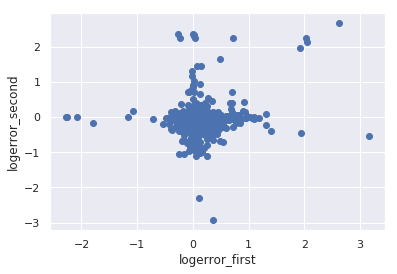

In [36]:
plt.xlabel('logerror_first')
plt.ylabel('logerror_second')
plt.scatter(sale_history['logerror_first'], sale_history['logerror_second'])

Based on the above discovery, we engineered lag features

In [21]:
train['year_copy'] = train['year']
train['month_copy'] = train['month']
train['month_block_copy'] = train['month_block']
train.drop(['year','month','month_block'], axis=1, inplace=True)

train.rename(columns= {'year_copy':'year',
                      'month_copy':'month',
                      'month_block_copy':'month_block'},inplace=True)

In [47]:
# Code for prev_logerror features
months = [10, 11, 12]
for month in months:
    tmp=train.loc[train['month_block']<month]
    # Get the latest sale record
    sale_last = tmp[['ParcelId',
                     'month_block',
                     'logerror']].groupby('ParcelId').nth(-1)
    
    sale_last.rename(columns={'logerror':f'prev_logerror_{month}',
                             'month_block':f'prev_month_{month}'},inplace=True)
    sale_last.reset_index(inplace = True)
    
    test_2016 = pd.merge(test_2016, sale_last, on = 'ParcelId', how='left')
    test_2016[f'month_interval_{month}'] = month - test_2016[f'prev_month_{month}']
    test_2016[f'has_history_{month}'] = 0
    test_2016.loc[test_2016[f'prev_logerror_{month}'].notnull(),f'has_history_{month}'] = 1
    
months = [10, 11, 12]
for month in months:
    tmp=train.loc[train['month_block']<(month+12)]
    # Get the latest sale record
    sale_last = tmp[['ParcelId',
                     'month_block',
                     'logerror']].groupby('ParcelId').nth(-1)
    sale_last.rename(columns={'logerror':f'prev_logerror_{month}',
                             'month_block':f'prev_month_{month}'},inplace=True)
    sale_last.reset_index(inplace = True)
    
    test_2017 = pd.merge(test_2017, sale_last, on = 'ParcelId', how='left')
    test_2017[f'month_interval_{month}'] = (month + 12) - test_2017[f'prev_month_{month}']
    test_2017[f'has_history_{month}'] = 0
    test_2017.loc[test_2017[f'prev_logerror_{month}'].notnull(),f'has_history_{month}'] = 1

In [22]:
train['prev_month'] = train.groupby('ParcelId')['month_block'].shift()
train['prev_logerror'] = train.groupby('ParcelId')['logerror'].shift()
train['month_interval'] = train['month_block'] - train['prev_month']
train['has_history'] = 0
train.loc[train['prev_logerror'].notnull(),'has_history'] = 1

In [103]:
with open('train.pickle', 'wb') as handle:
    pickle.dump(train_2016, handle, protocol = pickle.HIGHEST_PROTOCOL)

with open('test_2016.pickle', 'wb') as handle:
    pickle.dump(test_2016, handle, protocol = pickle.HIGHEST_PROTOCOL)
    
with open('test_2017.pickle', 'wb') as handle:
    pickle.dump(test_2017, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [14]:
with open('train.pickle', 'rb') as handle:
    train = pickle.load(handle)

with open('test_2016.pickle', 'rb') as handle:
    test_2016 = pickle.load(handle)
    
with open('test_2017.pickle', 'rb') as handle:
    test_2017 = pickle.load(handle)

# Modeling

In [23]:
# Time correlation is small here. Therefore shuffling the data doesn't make the result worse. In fact it slightly improve the result
n_splits = 5
#folds = TimeSeriesSplit(n_splits=n_splits)
folds = KFold(n_splits, shuffle = True, random_state = 3)
#folds = GroupKFold(n_splits=n_splits)

In [24]:
bad_col = ['logerror', 'oof', 'target', 'target_class', 'class_guess', 'prob', 'outlier', 'oof_regre', 'logerror_correction',
           'regionidcounty_target_mean_lag_3','regionidcounty_target_mean_lag_4',
           'heatingorsystemtypeid_target_mean_lag_3','heatingorsystemtypeid_target_mean_lag_4',
           'trend_county','regionidcounty_target_enc','heatingorsystemtypeid_target_enc', 'trend',
           'regionidcity_target_enc','regionidzip_target_enc','regionidneighborhood_target_enc',
           'regionidcounty','buildingclasstypeid','basementsqft','yardbuildingsqft26','architecturalstyletypeid',
           'finishedsquarefeet13','storytypeid','fips','regionidcounty_yearbuilt_mean',
          ]
features_0 = [feature for feature in train.columns if feature not in bad_col]

Tried ks_sample or pearson_correlation for feature selection. Both of them don't work

In [25]:
# Clip the target to allow more stable prediction results   &(train['prev_logerror'].notnull())
X_train = train.loc[(train['month_block']>3),features_0]
y_train = train.loc[(train['month_block']>3),'logerror'].clip(-1, 1)   # best -1,1

lgb model

In [26]:
# 'mae' as loss function is more robust
params = {'num_leaves': 64,                        # 256   best 64     
          'min_data_in_leaf': 200,                  # 200           
          'objective': 'mae',                     # mae     best 'mae'                        
          'max_depth': 10,                          # 10   best  10
          'learning_rate': 0.1,                    #  0.1    best 0.1  0.07          
          "boosting": "gbdt",             
          "bagging_freq": 1,                                    
          "bagging_fraction": 0.7,                  # 0.7   best 0.7                           
          'feature_fraction': 0.5,                  # 0.5   best 0.5
          "bagging_seed": 11,                      # 11              
          "metric": 'mae',                                       
          "verbosity": -1,                                       
          #'reg_alpha': 0.1,                                    
          #'reg_lambda': 0.05,
          'alpha': 0.5,                             # 0.5
         }

yes
Fold 1 started at Fri Apr 24 23:38:20 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[264]	training's l1: 0.0605181	valid_1's l1: 0.0640894
Fold 2 started at Fri Apr 24 23:38:37 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[239]	training's l1: 0.0609332	valid_1's l1: 0.0632794
Fold 3 started at Fri Apr 24 23:38:54 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[158]	training's l1: 0.0614643	valid_1's l1: 0.0642249
Fold 4 started at Fri Apr 24 23:39:07 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[229]	training's l1: 0.0608625	valid_1's l1: 0.0639427
Fold 5 started at Fri Apr 24 23:39:23 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[117]	training's l1: 0.0619607	valid_1's l1: 0.0643241
Train loss mean:

76.21701312065125

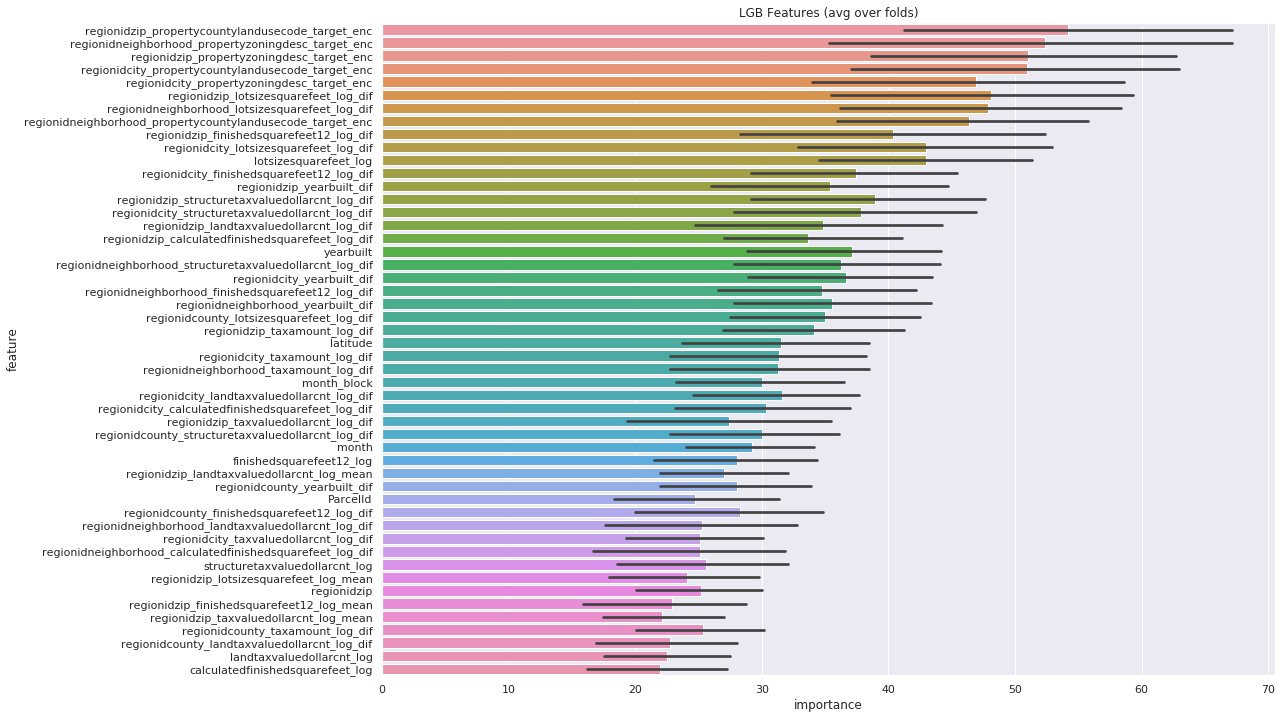

In [27]:
ts = time.time()

result_dict_lgb = train_model_regression_Zillow(
                         X=X_train, 
                         y=y_train, 
                         params=params, 
                         groups = None, 
                         folds=folds, model_type='lgb', eval_metric='mae', plot_feature_importance=True,
                          verbose=500, early_stopping_rounds=200, n_estimators=20000)

time.time()-ts

In [53]:
models = result_dict_lgb['models']

In [54]:
test_predict(test_2016, models, features_0, 2016)

7

In [55]:
test_predict(test_2017, models, features_0, 2017)

Clipping parameters testing. Intention is to figure out how does the out of fold prediction depends on the lower bound and upper bound of target clipping. Seems mae is more robust and not sensitive to the clipping parameters. It also gives better result compared to mse loss function.

In [41]:
params = {'num_leaves': 64,                        # 256   best 64     
          'min_data_in_leaf': 200,                  # 200           
          'objective': 'mae',                     # mae     best 'mae'                        
          'max_depth': 10,                          # 10   best  10
          'learning_rate': 0.1,                    #  0.1    best 0.1                
          "boosting": "gbdt",             
          "bagging_freq": 1,                                    
          "bagging_fraction": 0.7,                  # 0.7   best 0.7                           
          'feature_fraction': 0.5,                  # 0.5   best 0.5
          "bagging_seed": 11,                      # 11              
          "metric": 'mae',                                       
          "verbosity": -1,                                       
          #'reg_alpha': 0.1,                                    
          #'reg_lambda': 0.05,
          'alpha': 0.5                             # 0.5
         }

In [ ]:
lower_bounds = np.arange(-0.2, -0.07, 0.015)
upper_bounds = np.arange(0.08, 0.2, 0.015)
x = [] # lower_bounds
y = [] # upper_bounds
z = [] # mae
train_use = train.loc[train['month_block']>3]
for l_bound in lower_bounds:
    for u_bound in upper_bounds:
        X_train = train.loc[train['month_block']>3,features_0]
        y_train = train.loc[train['month_block']>3,'logerror'].clip(l_bound, u_bound)
        
        x.append(l_bound)
        y.append(u_bound)
        
        result_dict_lgb = train_model_regression_Zillow(
                                 X=X_train, 
                                 y=y_train, 
                                 params=params, 
                                 groups = None, 
                                 folds=folds, model_type='lgb', eval_metric='mae', plot_feature_importance=False,
                                  verbose=500, early_stopping_rounds=200, n_estimators=20000)
        
        train_use['oof'] = result_dict_lgb['oof']
        mae = mean_absolute_error(train_use['logerror'],train_use['oof'])
        
        z.append(mae)

Use mae as loss function

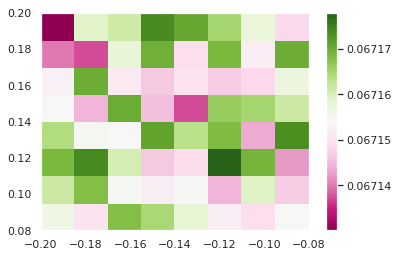

In [44]:
x_plot=np.unique(x)
y_plot=np.unique(y)
X,Y = np.meshgrid(x_plot,y_plot)

Z=z_plot.reshape(len(y_plot),len(x_plot))
cmap = plt.get_cmap('PiYG')

plt.pcolormesh(X,Y,Z, cmap = cmap)
plt.colorbar()

Use mse as loss function

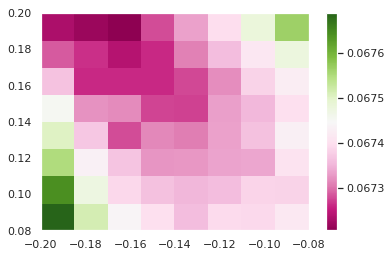

In [38]:
x_plot=np.unique(x)
y_plot=np.unique(y)
X,Y = np.meshgrid(x_plot,y_plot)

Z=z_plot.reshape(len(y_plot),len(x_plot))
cmap = plt.get_cmap('PiYG')

plt.pcolormesh(X,Y,Z, cmap = cmap)
plt.colorbar()

The reason why using previous logerror improves the private leaderboard rank but not on public leaderboard is due to that 2016 data doesn't have many samples with history

In [ ]:
tmp = train.loc[train['prev_logerror'].notnull()]

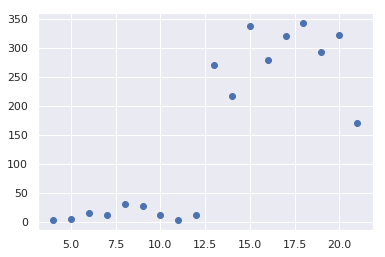

In [82]:
group = tmp.groupby('month_block').agg({'logerror':'count'})
group.columns=['count']
group.reset_index(inplace=True)

plt.scatter(group['month_block'],group['count'])

# Submissions

In [56]:
columns_submission = test_2017.columns[:7]
submission = test_2017[columns_submission]
submission = submission.round(4)
submission.to_csv('./submissions/submission_20200424_0.csv', index=False)

In [66]:
submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.0259,0.0257,0.0247,0.0273,0.0266,0.0261
1,10759547,0.0174,0.0173,0.0164,0.0192,0.0169,0.0161
2,10843547,0.0335,0.0339,0.0333,0.0338,0.0331,0.0330
3,10859147,0.0369,0.0368,0.0350,0.0369,0.0329,0.0315
4,10879947,0.0123,0.0130,0.0131,0.0123,0.0125,0.0126


Result blending

In [14]:
submission_1 = pd.read_csv('./submissions/submission_20200424_0.csv')
submission_2 = pd.read_csv('./submissions/submission_20200423_4.csv')
submission_3 = pd.read_csv('./submissions/submission_20200423_3.csv')
submission_4 = pd.read_csv('./submissions/submission_20200423_2.csv')

submission = submission_1.copy()

In [15]:
ratio_1 = 0.25
ratio_2 = 0.25
ratio_3 = 0.25

for feature in submission_1.columns:
    if feature == 'ParcelId':
        continue
        
    submission[feature] = submission_1[feature]*ratio_1 + \
                            submission_2[feature]*ratio_2 + \
                            submission_3[feature]*ratio_3 + \
                            submission_4[feature]*(1 - ratio_1 - ratio_2 - ratio_3)

In [16]:
submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.020425,0.021025,0.021425,0.024950,0.025600,0.025750
1,10759547,0.016875,0.017375,0.017825,0.020775,0.021200,0.021450
2,10843547,0.034175,0.034500,0.034925,0.043600,0.043825,0.044025
3,10859147,0.032525,0.032750,0.032850,0.034525,0.034750,0.034775
4,10879947,0.017925,0.018400,0.018850,0.020425,0.020575,0.020775


In [17]:
submission = submission.round(4)
submission.to_csv('./submissions/submission_20200425_0.csv', index=False)